# Technologie Sieciowe sprawozdanie z listy drugiej
*Paweł Data*

## Zadanie 1
Rozważmy model sieci S = <G,H>. Przez N=[n(i,j)] będziemy oznaczać macierz natężeń strumienia pakietów, gdzie element n(i,j) jest liczbą pakietów przesyłanych (wprowadzanych do sieci) w ciągu sekundy od źródła v(i) do ujścia v(j).

### Zadanie 1.1
Zaproponuj topologię grafu G ale tak aby żaden wierzchołek nie był izolowany oraz aby: |V|=20, |E|<30. Zaproponuj N oraz następujące funkcje krawędzi ze zbioru H: funkcję przepustowości 'c' (rozumianą jako maksymalną liczbę bitów, którą można wprowadzić do kanału komunikacyjnego w ciągu sekundy), oraz funkcję przepływu 'a' (rozumianą jako faktyczną liczbę pakietów, które wprowadza się do kanału komunikacyjego w ciągu sekundy). Pamiętaj aby funkcja przeplywu realizowała macierz N oraz aby dla każdego kanału 'e' zachodziło: c(e) > a(e).

We wszystkich zadaniach będę rozważał ten sam graf, połączony 26 krawędziami (pierwsze 19 z nich ustalam tak, by graf był spójny i 7 są ustalane losowo).

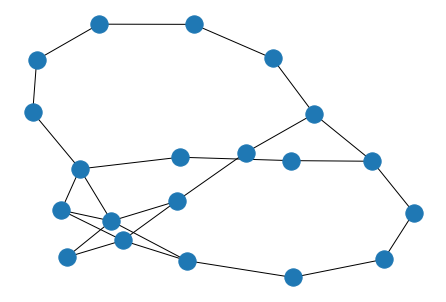

In [5]:
import networkx as nx
from random import randint

def addNewEdges(graph, number):
    while number > 0:
        node1 = randint(0, graph.number_of_nodes())
        node2 = randint(0, graph.number_of_nodes())
        if node1 != node2 and not graph.has_edge(node1, node2):
            graph.add_edge(node1, node2)
            number -= 1


graph = nx.Graph()
graph.add_nodes_from([i for i in range(20)])
graph.add_edges_from([(i, i + 1) for i in range(19)])
addNewEdges(graph, 7)

nx.draw(graph)


Ustalmy macierz N losowymi liczbami od 10 do 20,
funckję a jako suma przesyłanych bitów przez najkrótsze ścieżki, 
funkcję c jako stałą 2048.

In [6]:
N = [[randint(10,20) for _ in range(20)] for _ in range(20)]


def setA(graph, N):
    nx.set_edge_attributes(graph, 0, 'a')
    for i in range(20):
        for j in range(20):
            path = nx.shortest_path(graph, i, j)
            for k in range(len(path) - 1):
                graph[path[k]][path[k + 1]]['a'] += N[i][j]


setA(graph, N)
nx.set_edge_attributes(graph, 2048, 'c')


Sprawdźmy, czy c(e)/m > a(e) dla dażdej krawędzi. Przyjmijmy m = 1

In [7]:
m = 1

def check(graph):
    aValue = nx.get_edge_attributes(graph, 'a')
    cValue = nx.get_edge_attributes(graph, 'c')
    for edge in nx.edges(graph):
        if cValue[edge]/m <= aValue[edge]:
            return False
    return True


print(check(graph))


True


### Zadanie 1.2
Niech miarą niezawodności sieci jest prawdopodobieństwo tego, że w dowolnym przedziale czasowym, nierozspójniona sieć zachowuje T < T_max, gdzie: T = 1/G * SUM_e( a(e)/(c(e)/m - a(e)) ), jest średnim opóźnieniem pakietu w sieci, SUM_e oznacza sumowanie po wszystkich krawędziach 'e' ze zbioru E, 'G' jest sumą wszystkich elementów macierzy natężeń, a 'm' jest średnią wielkością pakietu w bitach. Napisz program szacujący niezawodność takiej sieci przyjmując, że prawdopodobieństwo nieuszkodzenia każdej krawędzi w dowolnym interwale jest równe 'p'. Uwaga: 'N', 'p', 'T_max' oraz topologia wyjsciowa sieci są parametrami.

In [8]:
from random import random


def delay(graph, N):
    aValue = nx.get_edge_attributes(graph, 'a')
    cValue = nx.get_edge_attributes(graph, 'c')
    return sum(aValue[edge] / (cValue[edge]/m - aValue[edge]) for edge in graph.edges())


def getReliability(graph, N, p, T_max, tries=1000):
    success = 0
    
    for _ in range(tries):
        tempG = nx.Graph(graph)
        tempG.remove_edges_from([edge for edge in tempG.edges() if random() > p ])
        
        if nx.is_connected(tempG):
            setA(tempG, N)
            if check(tempG) and delay(tempG, N) < T_max:
                if delay(tempG, N) < 0:
                    print('lipa')
                success += 1

    return success / tries


Ustalmy p i T_max

In [9]:
p = 0.9
T_max = 30


### Zadanie 1.3
Przy ustalonej strukturze topologicznej sieci i dobranych przepustowościach stopniowo zwiększaj wartości w macierzy natężeń. Jak będzie zmieniać się niezawodność zdefiniowana tak jak punkcie poprzednim (Pr[T < T_max])?

Aktualna niezawodność:

In [10]:
getReliability(graph, N, p, T_max)


0.387

W macierzy N są wartości między 10 a 20, będę te wartości zwiększał o 1 i sprawdzał niezawodność

In [12]:
for i in range(1, 9):
    tempN = [[x + i for x in line] for line in N]
    print('wiecej o', i, 'niezawodnosc', getReliability(graph, tempN, p, T_max)) 
    

wiecej o 1 niezawodnosc 0.384
wiecej o 2 niezawodnosc 0.283
wiecej o 3 niezawodnosc 0.192
wiecej o 4 niezawodnosc 0.147
wiecej o 5 niezawodnosc 0.124
wiecej o 6 niezawodnosc 0.0
wiecej o 7 niezawodnosc 0.0
wiecej o 8 niezawodnosc 0.0


Jak widać niezawodność znacznie spada przy większej ilości pakietów.

### Zadanie 1.4
Przy ustalonej macierzy natężeń i strukturze topologicznej stopniowo zwiększaj przepustowości. Jak będzie zmieniać się niezawodność zdefiniowana tak jak punkcie poprzednim (Pr[T < T_max])?

Teraz c wynosi 2048, tą wartość będę zwiększał i sprawdzę, jak zmieni się niezawodność

In [13]:
tempG = nx.Graph(graph)

for i in range(256, 4099, 256):
    nx.set_edge_attributes(tempG, 2048 + i, 'c')
    print('maks przepustowosc', 2048 + i, 'niezawodnosc', getReliability(tempG, N, p, T_max))
    

maks przepustowosc 2304 niezawodnosc 0.54
maks przepustowosc 2560 niezawodnosc 0.682
maks przepustowosc 2816 niezawodnosc 0.708
maks przepustowosc 3072 niezawodnosc 0.714
maks przepustowosc 3328 niezawodnosc 0.738
maks przepustowosc 3584 niezawodnosc 0.776
maks przepustowosc 3840 niezawodnosc 0.8
maks przepustowosc 4096 niezawodnosc 0.789
maks przepustowosc 4352 niezawodnosc 0.787
maks przepustowosc 4608 niezawodnosc 0.769
maks przepustowosc 4864 niezawodnosc 0.766
maks przepustowosc 5120 niezawodnosc 0.773
maks przepustowosc 5376 niezawodnosc 0.782
maks przepustowosc 5632 niezawodnosc 0.778
maks przepustowosc 5888 niezawodnosc 0.783
maks przepustowosc 6144 niezawodnosc 0.773


Zgodnie z intuicją, na początku niezawodność się zwiększa. Potem niezawodność przestaje rosnąć i mimo większej przepustowości jest stale w pewnym przedziale (który powstaje przez losowość w funkcji getReliability()). Wynika z tego, że od pewnej wysokiej wartości c większym problemem jest sama spójność grafu niż ograniczenie przepustowości.

### Zadanie 1.5
Przy ustalonej macierzy natężeń i pewnej początkowej strukturze topologicznej, stopniowo zmieniaj topologię poprzez dodawanie nowych krawędzi o przepustowościach będących wartościami średnimi dla sieci początkowej. Jak będzie zmieniać się niezawodność zdefiniowana tak jak punkcie poprzednim (Pr[T < T_max])?

Na początku ustaliłem ilość krawędzi równą 26.
Co petlę dodam 1 nową krawędź.

In [15]:
tempG = nx.Graph(graph)


for i in range(1, 16, 1):
    new = 0
    while new < 2:
        node1 = randint(0, tempG.number_of_nodes())
        node2 = randint(0, tempG.number_of_nodes())
        if not tempG.has_edge(node1, node2):
            tempG.add_edge(node1, node2)
            tempG[node1][node2]['c'] = 2048
            new += 1

    setA(tempG, N)
    print('ilosc krawedzi', 26 + i, 'niezawodnosc', getReliability(tempG, N, p, T_max))
    

ilosc krawedzi 27 niezawodnosc 0.528
ilosc krawedzi 28 niezawodnosc 0.686
ilosc krawedzi 29 niezawodnosc 0.829
ilosc krawedzi 30 niezawodnosc 0.911
ilosc krawedzi 31 niezawodnosc 0.821
ilosc krawedzi 32 niezawodnosc 0.756
ilosc krawedzi 33 niezawodnosc 0.758
ilosc krawedzi 34 niezawodnosc 0.696
ilosc krawedzi 35 niezawodnosc 0.778
ilosc krawedzi 36 niezawodnosc 0.77
ilosc krawedzi 37 niezawodnosc 0.806
ilosc krawedzi 38 niezawodnosc 0.786
ilosc krawedzi 39 niezawodnosc 0.782
ilosc krawedzi 40 niezawodnosc 0.794
ilosc krawedzi 41 niezawodnosc 0.897


Niezawodność z reguły rośnie. Są momenty, gdy maleje, ale jest to spowodowane tym, w jaki sposób zdefiniowałem trasę pakietów. W niektórych przypadkach dodanie jednej krawędzi może spowodować, że wiele pakietów zmieni trasę i wybieże nową przechodzącą przez własnie dodaną krawędź która będzie "wąskim gardłem".